#                          Teclov Project : Medical Treatment

Kaggle Link: https://www.kaggle.com/c/msk-redefining-cancer-treatment/overview

## Data Analysis

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [4]:
data_variants = pd.read_csv('Data/training_variants')
data_text =pd.read_csv("Data/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [5]:
data_variants.head(3)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


In [6]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [7]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [8]:
data_variants.shape

(3321, 4)

In [9]:
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

In [10]:
data_text.head(3)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...


In [11]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [12]:
data_text.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [13]:
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [14]:
data_text.shape

(3321, 2)

In [15]:
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

it is ***classification*** problem and since there are multiple descrete output possible so we can call it ***Multi class*** classification problem

In [16]:
stop_words = set(stopwords.words('english'))

In [17]:
def data_text_preprocess(total_text, ind, col):
    if type(total_text) is not int:
        string = ""
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        total_text = re.sub('\s+',' ', str(total_text))
        total_text = total_text.lower()
        
        for word in total_text.split():
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

In [18]:
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

In [19]:
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [20]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [21]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [22]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


In [23]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

In [24]:
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [25]:
y_test

array([2, 7, 6, 5, 5, 7, 2, 1, 1, 5, 5, 1, 4, 1, 7, 4, 5, 7, 5, 2, 6, 3,
       7, 7, 4, 2, 2, 7, 1, 4, 2, 1, 4, 1, 4, 1, 8, 4, 4, 1, 4, 6, 2, 7,
       7, 7, 1, 7, 7, 3, 4, 4, 7, 1, 7, 7, 5, 7, 4, 1, 1, 7, 1, 2, 7, 4,
       1, 1, 6, 4, 2, 7, 7, 1, 7, 9, 7, 1, 7, 7, 5, 7, 3, 4, 5, 4, 7, 7,
       7, 5, 6, 1, 7, 3, 2, 2, 4, 4, 1, 7, 4, 7, 2, 1, 4, 7, 7, 7, 7, 1,
       1, 7, 7, 2, 7, 4, 4, 1, 2, 7, 7, 4, 2, 4, 2, 7, 7, 1, 4, 4, 2, 7,
       2, 1, 1, 1, 4, 2, 2, 3, 4, 2, 6, 4, 5, 1, 4, 7, 1, 2, 5, 2, 4, 6,
       5, 1, 6, 1, 6, 7, 2, 2, 7, 5, 7, 2, 2, 4, 1, 7, 1, 2, 7, 4, 7, 4,
       9, 3, 7, 1, 7, 7, 1, 4, 7, 1, 6, 7, 4, 5, 2, 7, 6, 5, 4, 4, 5, 1,
       1, 1, 4, 1, 1, 2, 2, 9, 4, 1, 5, 6, 7, 6, 7, 1, 2, 7, 1, 4, 7, 4,
       2, 5, 7, 5, 7, 9, 1, 5, 4, 8, 6, 4, 7, 7, 7, 4, 1, 6, 5, 7, 1, 7,
       2, 4, 4, 4, 4, 2, 4, 1, 6, 4, 7, 2, 1, 7, 1, 8, 4, 7, 7, 7, 1, 1,
       5, 1, 5, 2, 7, 4, 7, 7, 6, 2, 1, 7, 4, 7, 4, 4, 2, 4, 6, 2, 4, 4,
       3, 2, 2, 6, 4, 7, 7, 7, 7, 4, 4, 6, 7, 4, 2,

In [26]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [27]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

In [28]:
train_class_distribution

1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: Class, dtype: int64

*** Visualizing for train class distrubution***

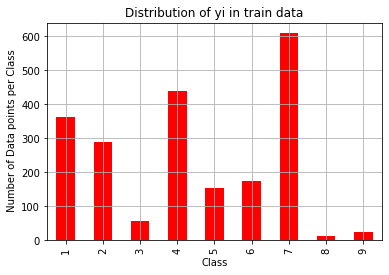

In [29]:
from matplotlib.colors import ListedColormap

my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']  # red, green, blue, black, etc.
my_colormap = ListedColormap(my_colors)

train_class_distribution.plot(kind='bar',colormap=my_colormap)
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

In [30]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


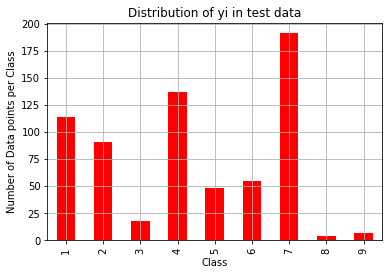

In [31]:
from matplotlib.colors import ListedColormap

my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']  # red, green, blue, black, etc.
my_colormap = ListedColormap(my_colors)

test_class_distribution.plot(kind='bar',colormap=my_colormap)
plt.xlabel('Class')
plt.ylabel('Number of Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

In [32]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


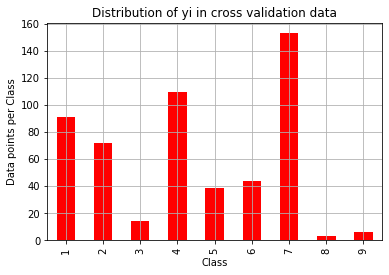

In [33]:
from matplotlib.colors import ListedColormap

my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']  # red, green, blue, black, etc.
my_colormap = ListedColormap(my_colors)

cv_class_distribution.plot(kind='bar',colormap=my_colormap)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

In [34]:
sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


## Building a Random model

In [35]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [36]:
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.5212395928837106


In [37]:
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))


Log loss on Test Data using Random Model 2.4489846470795276


In [38]:
predicted_y =np.argmax(test_predicted_y, axis=1)

In [39]:
predicted_y

array([1, 6, 4, 0, 4, 3, 2, 7, 2, 3, 1, 2, 6, 6, 6, 7, 1, 7, 1, 7, 2, 6,
       5, 0, 7, 2, 5, 5, 3, 6, 2, 5, 1, 1, 4, 5, 2, 8, 7, 1, 0, 2, 5, 8,
       0, 5, 3, 0, 1, 5, 7, 7, 3, 1, 6, 7, 6, 1, 8, 1, 2, 7, 2, 1, 6, 8,
       5, 0, 0, 3, 2, 7, 6, 2, 3, 0, 7, 8, 3, 7, 3, 0, 5, 3, 8, 3, 4, 3,
       2, 1, 0, 7, 3, 4, 2, 2, 8, 8, 8, 8, 1, 0, 4, 8, 2, 2, 1, 7, 6, 1,
       6, 5, 1, 8, 7, 4, 5, 2, 5, 6, 2, 1, 4, 2, 4, 1, 5, 1, 5, 0, 4, 8,
       0, 7, 6, 8, 0, 3, 5, 4, 0, 0, 2, 8, 4, 6, 4, 8, 6, 8, 8, 4, 4, 4,
       7, 2, 6, 0, 6, 7, 2, 1, 2, 2, 5, 1, 4, 8, 7, 4, 2, 6, 8, 4, 6, 4,
       7, 7, 3, 7, 8, 7, 1, 8, 5, 4, 4, 6, 8, 4, 0, 6, 2, 7, 2, 8, 5, 4,
       8, 6, 0, 1, 4, 8, 8, 3, 6, 2, 1, 2, 2, 0, 5, 0, 2, 1, 6, 8, 1, 3,
       8, 0, 5, 2, 8, 1, 1, 4, 6, 8, 5, 5, 7, 2, 8, 6, 0, 1, 0, 4, 1, 5,
       8, 8, 3, 6, 4, 5, 5, 6, 1, 1, 5, 2, 5, 2, 7, 6, 8, 3, 4, 7, 7, 7,
       1, 1, 8, 3, 1, 8, 7, 6, 4, 2, 2, 6, 4, 5, 8, 6, 5, 1, 8, 3, 3, 5,
       8, 3, 1, 5, 8, 0, 2, 2, 3, 7, 8, 2, 3, 7, 7,

In [40]:
predicted_y = predicted_y + 1

### Confusion Matrix

In [41]:
C = confusion_matrix(y_test, predicted_y)


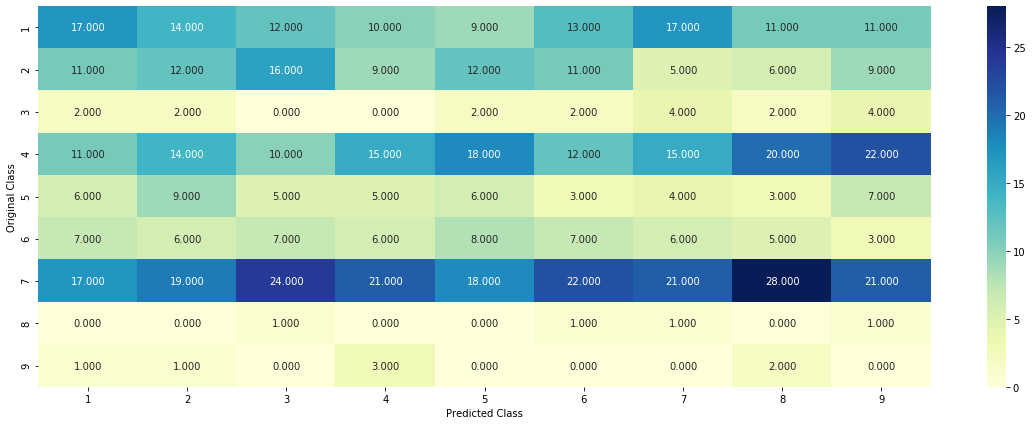

In [42]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### Precision matrix

In [43]:
B =(C/C.sum(axis=0))

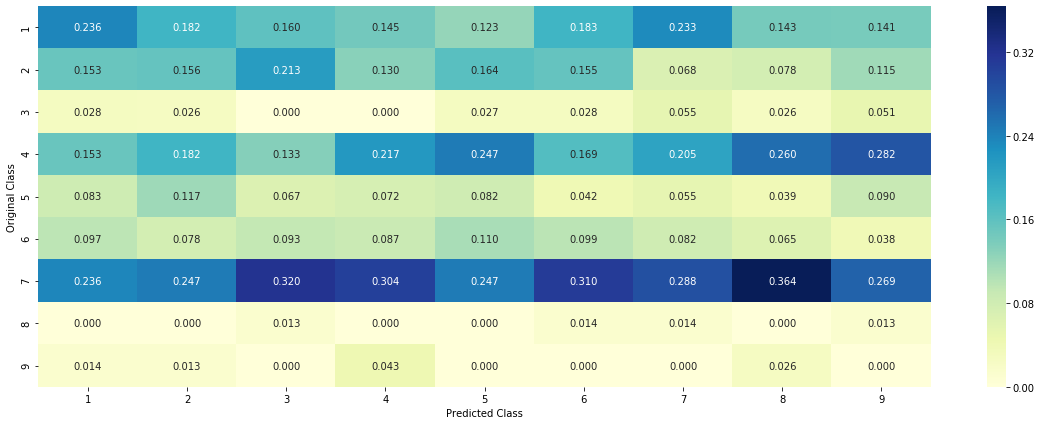

In [44]:
plt.figure(figsize=(20,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### Recall matrix

In [45]:
A =(((C.T)/(C.sum(axis=1))).T)

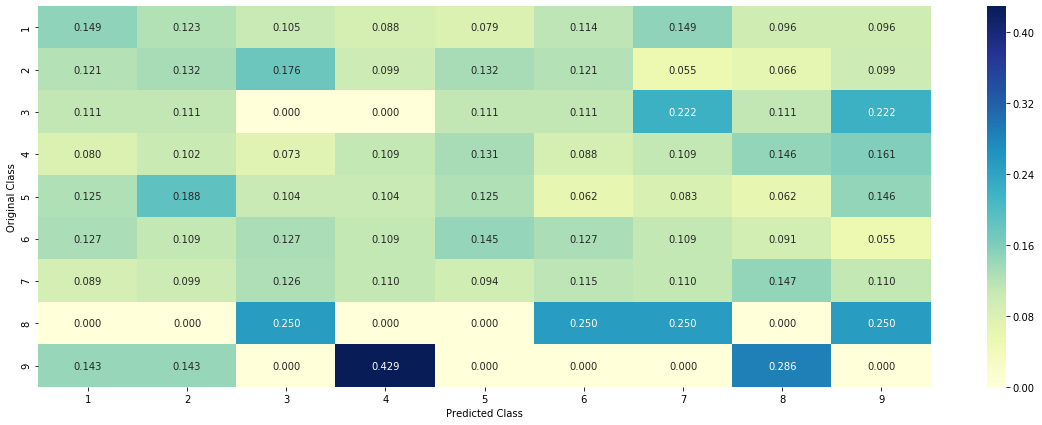

In [46]:
plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

## Exploring Gene Column

In [47]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
print(unique_genes.head(10))

Number of Unique Genes : 232
BRCA1     172
TP53      107
EGFR       89
BRCA2      84
PTEN       80
KIT        65
BRAF       56
ALK        42
ERBB2      42
PDGFRA     37
Name: Gene, dtype: int64


In [48]:
unique_genes.shape[0]

232

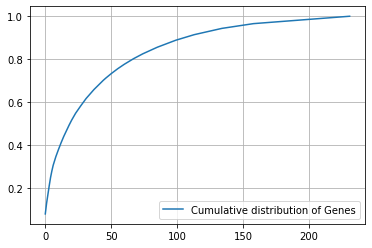

In [49]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()


converting categorical variables
<ol><li>
     ***One-hot encoding*** </li>
    <li> ***Response Encoding*** (Mean imputation) </li>
</ol>

In [50]:
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [51]:
train_gene_feature_onehotCoding.shape

(2124, 232)

In [52]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl2',
 'atm',
 'atrx',
 'aurka',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gata3',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbke',
 'il7

In [53]:
# code for response coding with Laplace smoothing.
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    
    gv_dict = dict()
    
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

In [54]:
# response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [55]:
train_gene_feature_responseCoding.shape

(2124, 9)

In [56]:
alpha = [10 ** x for x in range(-5, 1)]

In [57]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# using Calibrated Classifier to get the result into probablity format to be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.2193863604081148
For values of alpha =  0.0001 The log loss is: 1.2046386453894742
For values of alpha =  0.001 The log loss is: 1.2508968848017321
For values of alpha =  0.01 The log loss is: 1.356286555341722
For values of alpha =  0.1 The log loss is: 1.4511593987494582
For values of alpha =  1 The log loss is: 1.485903094831825


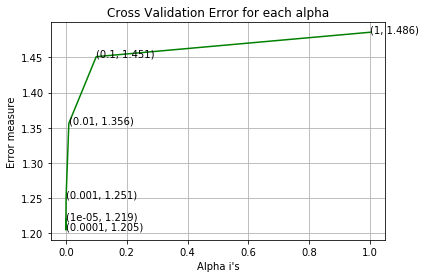

In [58]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [59]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 0.9798804995056806
For values of best alpha =  0.0001 The cross validation log loss is: 1.2046386453894742
For values of best alpha =  0.0001 The test log loss is: 1.1964054146458885


In [60]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [61]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 646 out of 665 : 97.14285714285714
2. In cross validation data 515 out of  532 : 96.80451127819549


## Exploring Variation column

In [62]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
print(unique_variations.head(10))

Number of Unique Variations : 1937
Truncating_Mutations    57
Amplification           46
Deletion                44
Fusions                 23
Y64A                     2
I31M                     2
K117N                    2
Q209L                    2
P34R                     2
M1R                      2
Name: Variation, dtype: int64


[0.02683616 0.04849341 0.06920904 ... 0.99905838 0.99952919 1.        ]


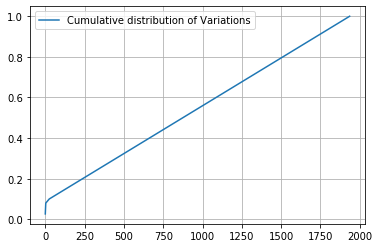

In [63]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [64]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [65]:
train_variation_feature_onehotCoding.shape

(2124, 1969)

In [66]:
alpha = 1
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [67]:
train_variation_feature_responseCoding.shape

(2124, 9)

In [68]:
alpha = [10 ** x for x in range(-5, 1)]

In [69]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.68894132774506
For values of alpha =  0.0001 The log loss is: 1.6865113084960237
For values of alpha =  0.001 The log loss is: 1.6921585182134808
For values of alpha =  0.01 The log loss is: 1.7090715975816444
For values of alpha =  0.1 The log loss is: 1.7214109875578656
For values of alpha =  1 The log loss is: 1.7216142631945897


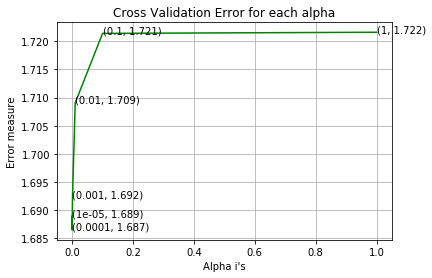

In [70]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [71]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.7256041256342285
For values of best alpha =  0.0001 The cross validation log loss is: 1.6865113084960237
For values of best alpha =  0.0001 The test log loss is: 1.7080558233624166


In [72]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [73]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 71 out of 665 : 10.676691729323307
2. In cross validation data 63 out of  532 : 11.842105263157894


## Exploring Text column

In [74]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [75]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):  
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [76]:
# CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53059


In [77]:
dict_list = []
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    dict_list.append(extract_dictionary_paddle(cls_text))

total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [78]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [79]:
# https://stackoverflow.com/a/16202486
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [80]:
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [81]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [82]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5155, 4: 3863, 5: 2971, 6: 2774, 7: 2206, 8: 2018, 9: 1998, 10: 1320, 11: 1221, 12: 1105, 14: 960, 15: 956, 16: 878, 18: 839, 13: 817, 17: 569, 21: 512, 20: 509, 19: 499, 27: 454, 22: 445, 24: 436, 26: 378, 25: 376, 23: 365, 28: 355, 30: 343, 45: 330, 32: 314, 29: 306, 50: 283, 36: 270, 31: 252, 35: 244, 33: 236, 40: 231, 38: 219, 37: 218, 34: 215, 39: 200, 42: 193, 54: 175, 46: 170, 41: 167, 51: 164, 44: 164, 49: 156, 52: 155, 47: 155, 48: 153, 43: 146, 55: 141, 56: 137, 63: 128, 60: 128, 53: 126, 59: 124, 58: 123, 57: 119, 65: 114, 64: 112, 61: 112, 76: 104, 62: 99, 72: 98, 67: 98, 74: 94, 66: 91, 69: 88, 78: 87, 71: 84, 90: 82, 75: 81, 70: 79, 68: 79, 88: 78, 77: 78, 79: 77, 80: 75, 73: 75, 86: 70, 83: 69, 95: 68, 82: 68, 81: 67, 100: 66, 84: 66, 93: 64, 85: 63, 97: 61, 94: 60, 91: 59, 120: 58, 104: 57, 96: 57, 87: 57, 115: 56, 113: 56, 110: 56, 99: 55, 103: 53, 92: 53, 114: 52, 107: 52, 106: 50, 130: 48, 132: 47, 127: 47, 116: 47, 102: 47, 134: 46, 109: 46, 89: 46, 111:

In [83]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.324443930911867
For values of alpha =  0.0001 The log loss is: 1.2456836050358961
For values of alpha =  0.001 The log loss is: 1.2459255035450507
For values of alpha =  0.01 The log loss is: 1.3498810056815074
For values of alpha =  0.1 The log loss is: 1.4339568048164708
For values of alpha =  1 The log loss is: 1.6270831084456248


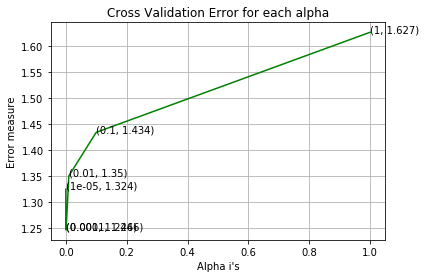

In [84]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [85]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 0.6674086144402
For values of best alpha =  0.0001 The cross validation log loss is: 1.2456836050358961
For values of best alpha =  0.0001 The test log loss is: 1.254340677405484


Lets check the overlap of text data

In [86]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [87]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.409 % of word of test data appeared in train data
97.987 % of word of Cross Validation appeared in train data


=>   all 3 columns are important.

## Data prepration

Sample Functions to reuse

In [88]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [89]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [90]:
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

## Combining all 3 features together

In [91]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [92]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55260)
(number of data points * number of features) in test data =  (665, 55260)
(number of data points * number of features) in cross validation data = (532, 55260)


In [93]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


# Building Machine Learning model

Lets start the first model which is most suitable when we have lot of text column data. So, we will start with Naive Bayes.

# Naive Bayes

In [94]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-05
Log Loss : 1.3035430211492733
for alpha = 0.0001
Log Loss : 1.2946075295058879
for alpha = 0.001
Log Loss : 1.2972483264754453
for alpha = 0.1
Log Loss : 1.2785490541395044
for alpha = 1
Log Loss : 1.3011923591557566
for alpha = 10
Log Loss : 1.3770577019680688
for alpha = 100
Log Loss : 1.4343960881746538
for alpha = 1000
Log Loss : 1.3798497025893002


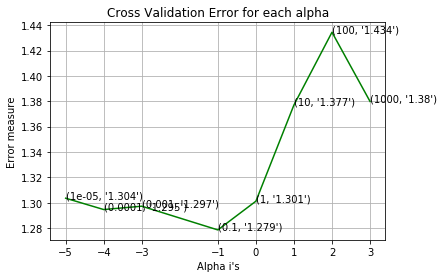

In [95]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [96]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.1 The train log loss is: 0.8444876281799352
For values of best alpha =  0.1 The cross validation log loss is: 1.2785490541395044
For values of best alpha =  0.1 The test log loss is: 1.259082144428502


Testing our Naive Bayes model with best found value of alpha on testing data

Log Loss : 1.2785490541395044
Number of missclassified point : 0.40977443609022557
-------------------- Confusion matrix --------------------


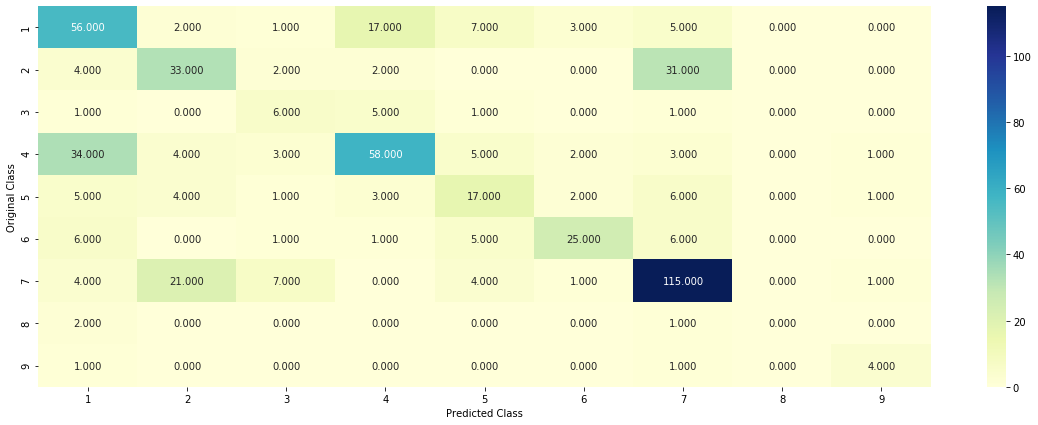

-------------------- Precision matrix (Columm Sum=1) --------------------


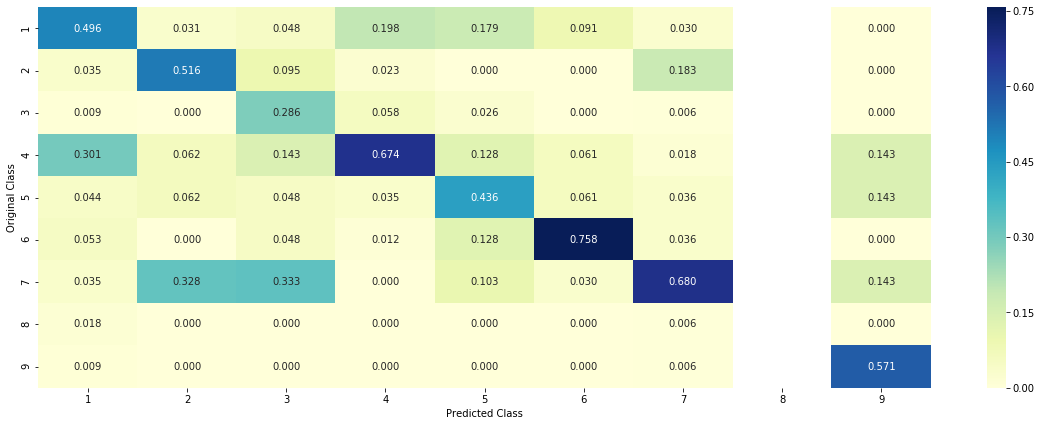

-------------------- Recall matrix (Row sum=1) --------------------


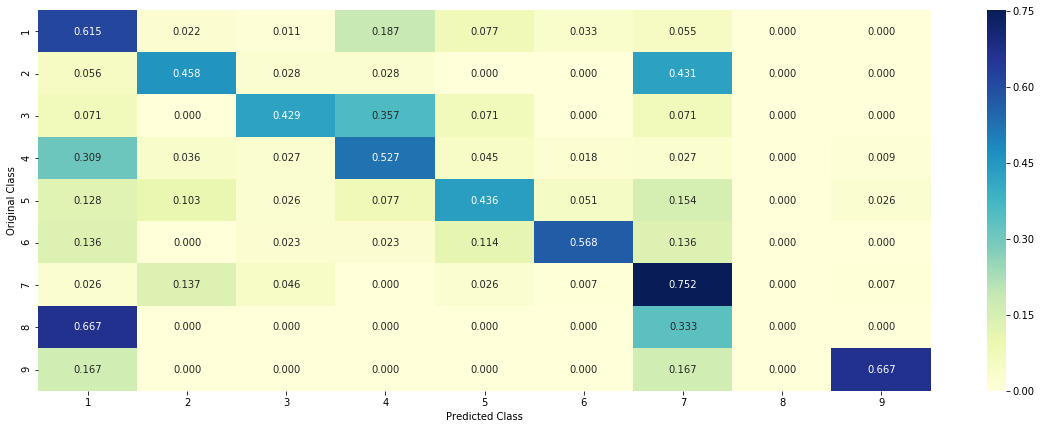

In [97]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

### Interpretability of our model

In [98]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0844 0.2535 0.0132 0.1066 0.0396 0.0329 0.4606 0.0051 0.004 ]]
Actual Class : 7
--------------------------------------------------
18 Text feature [presence] present in test data point [True]
19 Text feature [downstream] present in test data point [True]
20 Text feature [kinase] present in test data point [True]
21 Text feature [activating] present in test data point [True]
22 Text feature [contrast] present in test data point [True]
23 Text feature [expressing] present in test data point [True]
24 Text feature [independent] present in test data point [True]
25 Text feature [showed] present in test data point [True]
26 Text feature [activation] present in test data point [True]
27 Text feature [potential] present in test data point [True]
28 Text feature [inhibitor] present in test data point [True]
30 Text feature [recently] present in test data point [True]
31 Text feature [growth] present in test data point [True]
32 Text featur

Lets look at one more point

In [99]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0734 0.0604 0.0114 0.6668 0.0344 0.0286 0.1169 0.0044 0.0036]]
Actual Class : 4
--------------------------------------------------
10 Text feature [function] present in test data point [True]
12 Text feature [protein] present in test data point [True]
13 Text feature [experiments] present in test data point [True]
14 Text feature [proteins] present in test data point [True]
15 Text feature [missense] present in test data point [True]
16 Text feature [mammalian] present in test data point [True]
17 Text feature [functional] present in test data point [True]
18 Text feature [activity] present in test data point [True]
19 Text feature [acid] present in test data point [True]
20 Text feature [amino] present in test data point [True]
25 Text feature [suppressor] present in test data point [True]
26 Text feature [results] present in test data point [True]
27 Text feature [type] present in test data point [True]
28 Text feature [retained]

So Naive Bayes not performing very badly but lets look at other models

# K Nearest Neighbour Classification

In [100]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 5
Log Loss : 1.1302752304092343
for alpha = 11
Log Loss : 1.1179951076230583
for alpha = 15
Log Loss : 1.12491896156816
for alpha = 21
Log Loss : 1.123500890874589
for alpha = 31
Log Loss : 1.1205475755969334
for alpha = 41
Log Loss : 1.1238110834731045
for alpha = 51
Log Loss : 1.1265193554944675
for alpha = 99
Log Loss : 1.1577351110338137


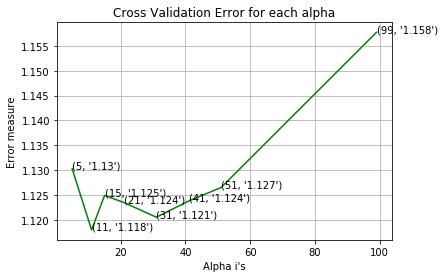

In [101]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [102]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  11 The train log loss is: 0.6019308053442013
For values of best alpha =  11 The cross validation log loss is: 1.1179951076230583
For values of best alpha =  11 The test log loss is: 1.0831212908934118


Log loss : 1.1179951076230583
Number of mis-classified points : 0.3815789473684211
-------------------- Confusion matrix --------------------


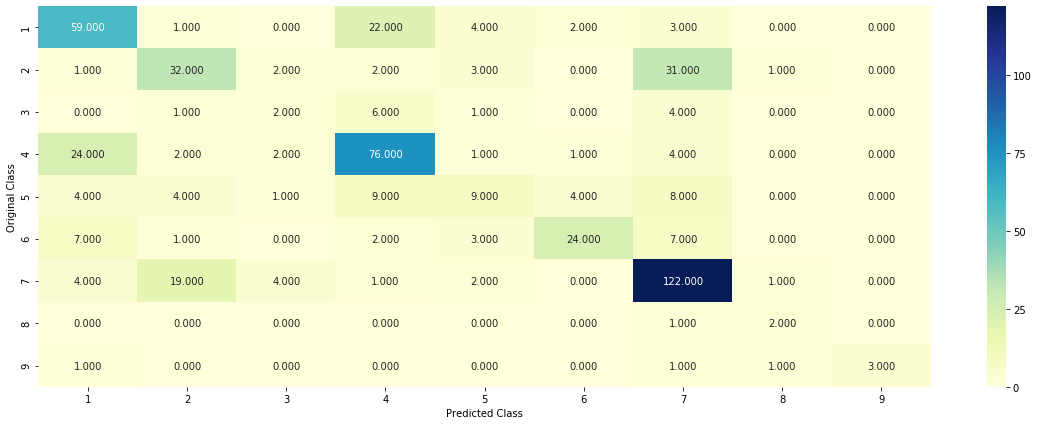

-------------------- Precision matrix (Columm Sum=1) --------------------


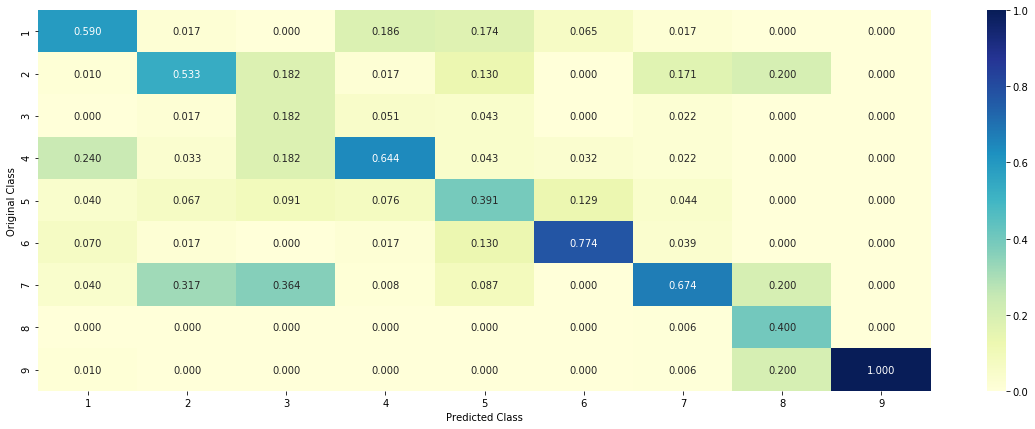

-------------------- Recall matrix (Row sum=1) --------------------


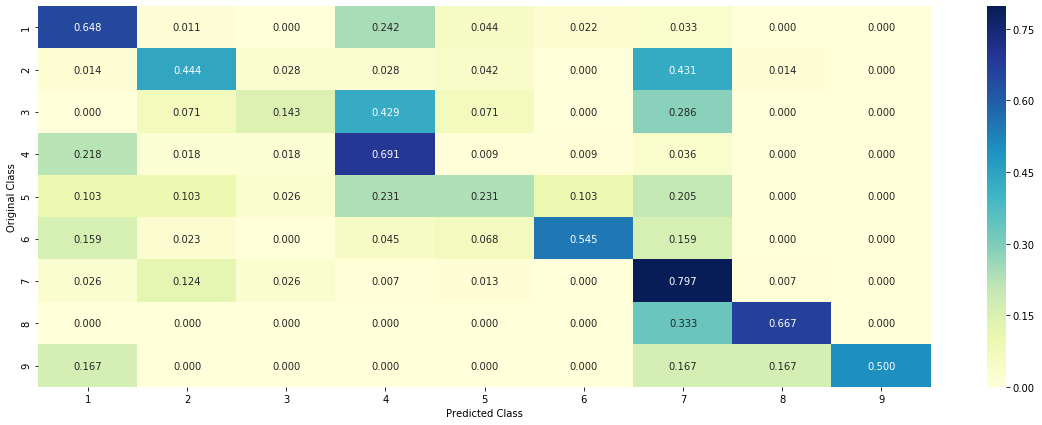

In [103]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [104]:
# Lets look at few test points
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 7
The  11  nearest neighbours of the test points belongs to classes [7 7 7 7 7 6 7 7 2 7 7]
Fequency of nearest points : Counter({7: 9, 6: 1, 2: 1})


In [105]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 10

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 5
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [1 6 1 6 6 4 5 4 4 5 5]
Fequency of nearest points : Counter({6: 3, 4: 3, 5: 3, 1: 2})


# Logistic Regression

### Balancing all classes

In [106]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.3538731026337276
for alpha = 1e-05
Log Loss : 1.3121556885666783
for alpha = 0.0001
Log Loss : 1.1929956350726467
for alpha = 0.001
Log Loss : 1.1811908875750121
for alpha = 0.01
Log Loss : 1.235848957604621
for alpha = 0.1
Log Loss : 1.4916111482261991
for alpha = 1
Log Loss : 1.6963258420837617
for alpha = 10
Log Loss : 1.721092695039016
for alpha = 100
Log Loss : 1.7238853266382959


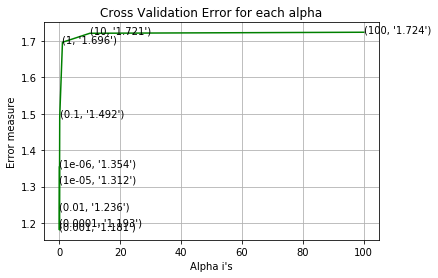

In [107]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [108]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42) #loss for LR is log. If we put 'hinge' there it will be SVM
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5067456529771223
For values of best alpha =  0.001 The cross validation log loss is: 1.1811908875750121
For values of best alpha =  0.001 The test log loss is: 1.1904881234335922


Log loss : 1.1811908875750121
Number of mis-classified points : 0.35526315789473684
-------------------- Confusion matrix --------------------


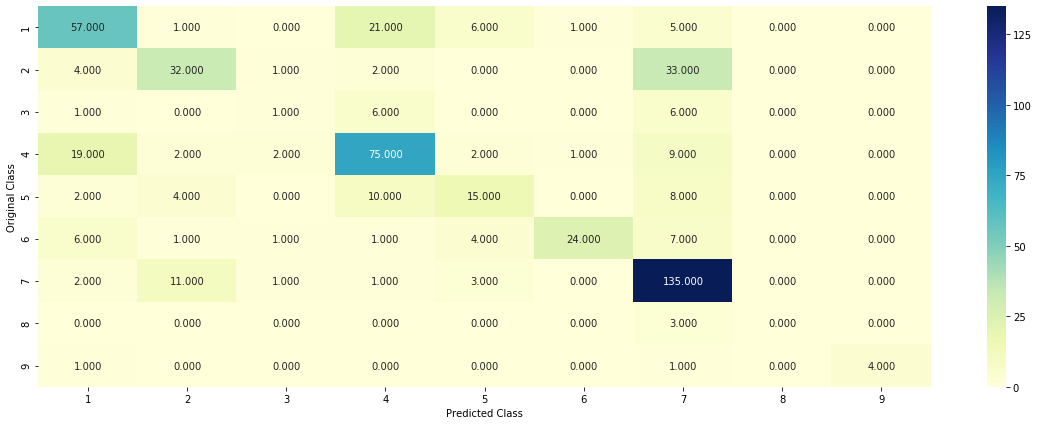

-------------------- Precision matrix (Columm Sum=1) --------------------


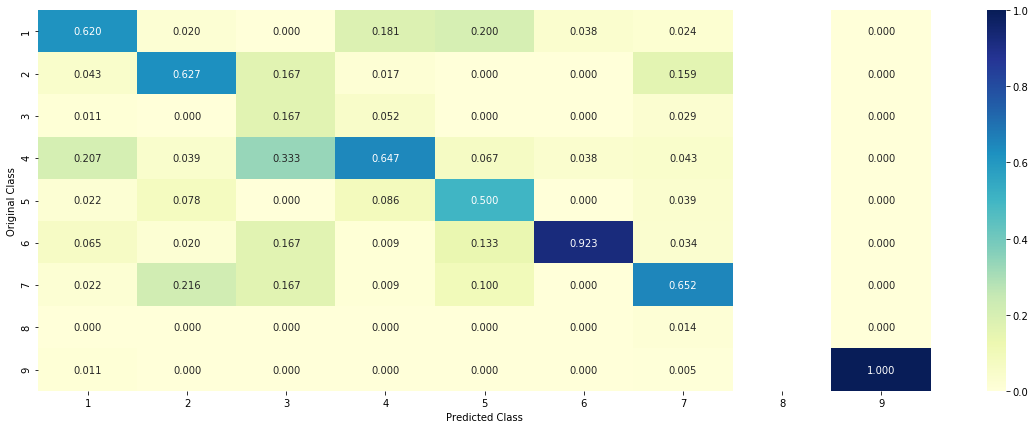

-------------------- Recall matrix (Row sum=1) --------------------


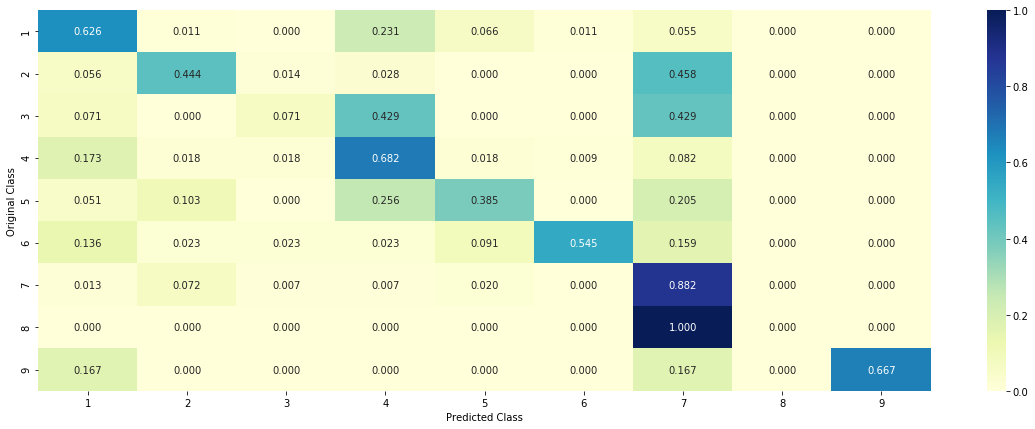

In [109]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### Feature importance

In [110]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [111]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0599 0.1329 0.0173 0.0625 0.0471 0.0399 0.6254 0.0065 0.0083]]
Actual Class : 7
--------------------------------------------------
65 Text feature [constitutively] present in test data point [True]
72 Text feature [transforming] present in test data point [True]
85 Text feature [transformation] present in test data point [True]
86 Text feature [nude] present in test data point [True]
89 Text feature [h2110] present in test data point [True]
93 Text feature [transform] present in test data point [True]
94 Text feature [activated] present in test data point [True]
102 Text feature [oncogenes] present in test data point [True]
107 Text feature [agar] present in test data point [True]
162 Text feature [s473] present in test data point [True]
163 Text feature [1092] present in test data point [True]
164 Text feature [expressing] present in test data point [True]
194 Text feature [pc6] present in test data point [True]
211 Text feature [

In [112]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0177 0.0078 0.0015 0.9479 0.0066 0.0025 0.0079 0.0058 0.0023]]
Actual Class : 4
--------------------------------------------------
83 Text feature [suppressor] present in test data point [True]
91 Text feature [ix] present in test data point [True]
231 Text feature [nonsense] present in test data point [True]
302 Text feature [phosphatases] present in test data point [True]
360 Text feature [avizienyte] present in test data point [True]
446 Text feature [inheritance] present in test data point [True]
453 Text feature [recombination] present in test data point [True]
461 Text feature [giardiello] present in test data point [True]
468 Text feature [151623] present in test data point [True]
483 Text feature [stability] present in test data point [True]
488 Text feature [yeast] present in test data point [True]
Out of the top  500  features  11 are present in query point


## Without class balancing

In [113]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.358844645080794
for alpha = 1e-05
Log Loss : 1.2972153962864648
for alpha = 0.0001
Log Loss : 1.1983030536797443
for alpha = 0.001
Log Loss : 1.2019399536450537
for alpha = 0.01
Log Loss : 1.3059893015413502
for alpha = 0.1
Log Loss : 1.3848989620345944
for alpha = 1
Log Loss : 1.5696826131674695


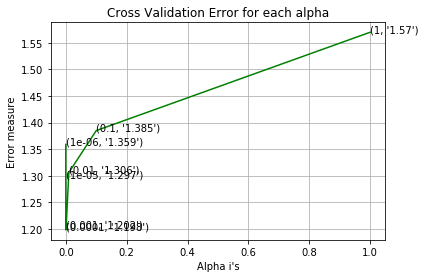

In [114]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [115]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.4716990241168039
For values of best alpha =  0.0001 The cross validation log loss is: 1.1983030536797443
For values of best alpha =  0.0001 The test log loss is: 1.234408709464118


Lets test our model with best hyper param

Log loss : 1.1983030536797443
Number of mis-classified points : 0.34398496240601506
-------------------- Confusion matrix --------------------


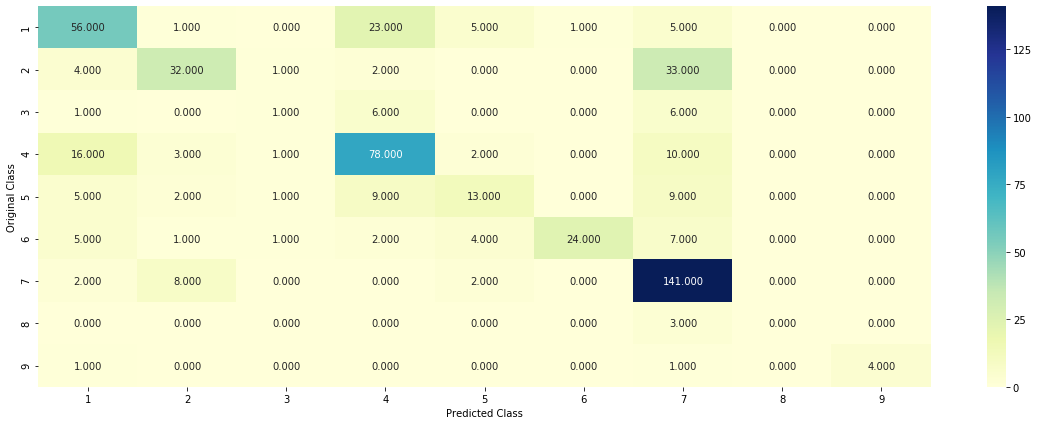

-------------------- Precision matrix (Columm Sum=1) --------------------


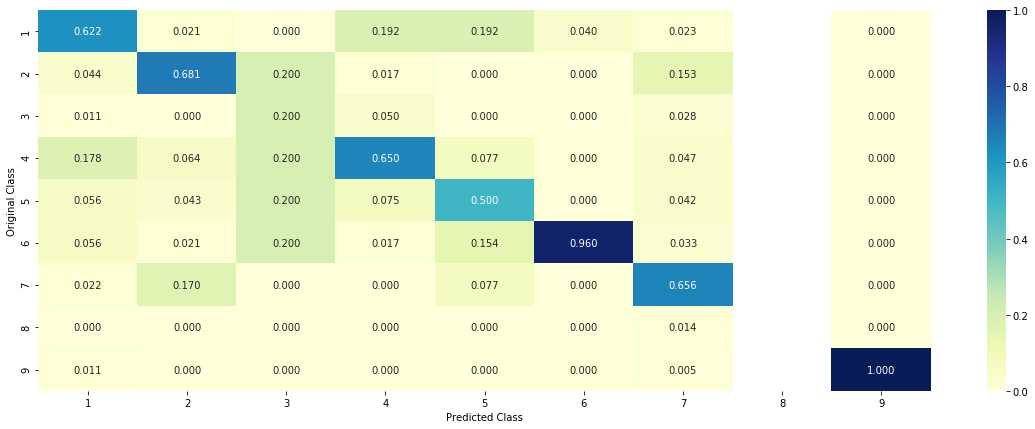

-------------------- Recall matrix (Row sum=1) --------------------


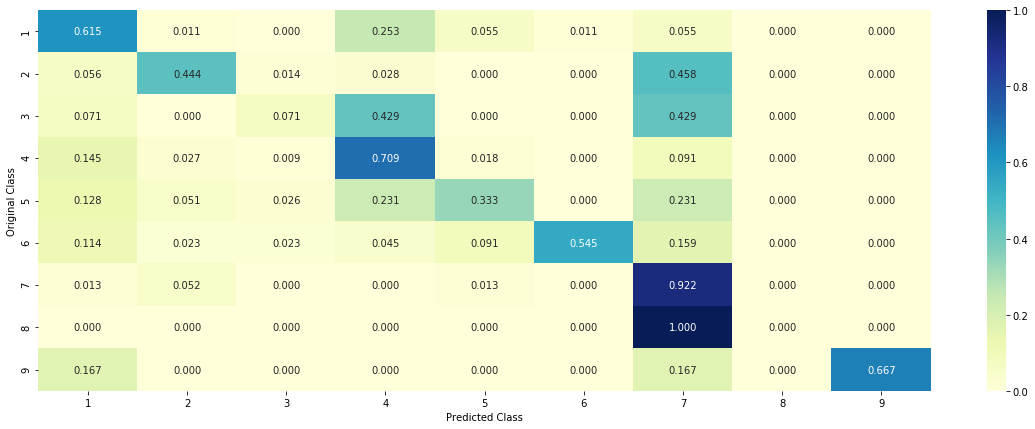

In [116]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### Testing query point and interpretability

In [117]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0534 0.1055 0.0164 0.0473 0.0434 0.0333 0.687  0.0062 0.0075]]
Actual Class : 7
--------------------------------------------------
144 Text feature [h2110] present in test data point [True]
173 Text feature [pc6] present in test data point [True]
179 Text feature [q79l] present in test data point [True]
262 Text feature [rit1] present in test data point [True]
264 Text feature [transforming] present in test data point [True]
285 Text feature [constitutively] present in test data point [True]
295 Text feature [malignancies23] present in test data point [True]
311 Text feature [1092] present in test data point [True]
335 Text feature [agar] present in test data point [True]
345 Text feature [transform] present in test data point [True]
355 Text feature [transformation] present in test data point [True]
446 Text feature [hras] present in test data point [True]
450 Text feature [expressing] present in test data point [True]
461 Text fe

# Linear Support Vector Machines

for C = 1e-05
Log Loss : 1.3149987651758661
for C = 0.0001
Log Loss : 1.2582119083297194
for C = 0.001
Log Loss : 1.169957212839251
for C = 0.01
Log Loss : 1.156656073886576
for C = 0.1
Log Loss : 1.408858264282152
for C = 1
Log Loss : 1.716373334051282
for C = 10
Log Loss : 1.7244006436525794
for C = 100
Log Loss : 1.7243990994708152


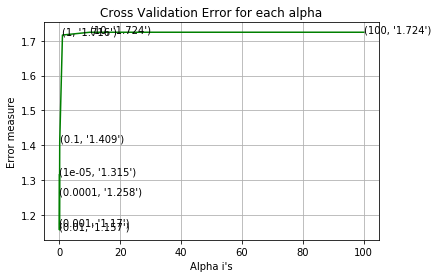

For values of best alpha =  0.01 The train log loss is: 0.7118679266990409
For values of best alpha =  0.01 The cross validation log loss is: 1.156656073886576
For values of best alpha =  0.01 The test log loss is: 1.1828410407426544


In [118]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Testing model with best alpha values

Log loss : 1.156656073886576
Number of mis-classified points : 0.34774436090225563
-------------------- Confusion matrix --------------------


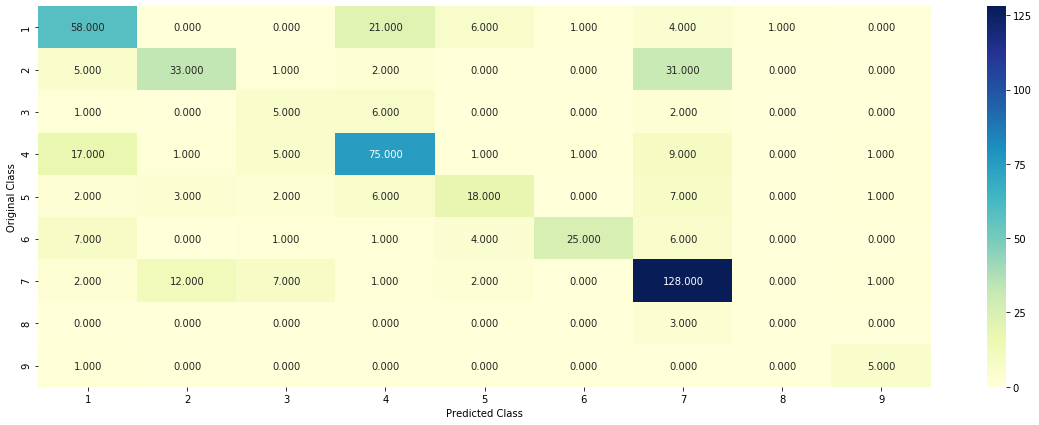

-------------------- Precision matrix (Columm Sum=1) --------------------


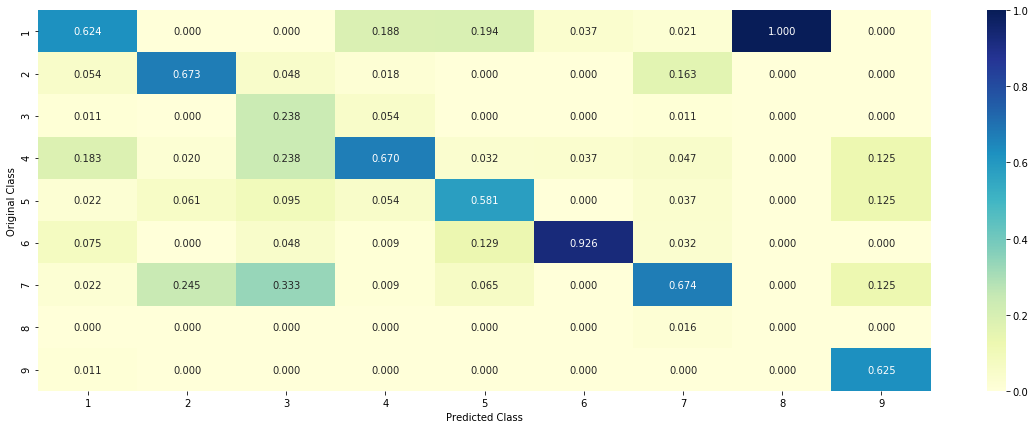

-------------------- Recall matrix (Row sum=1) --------------------


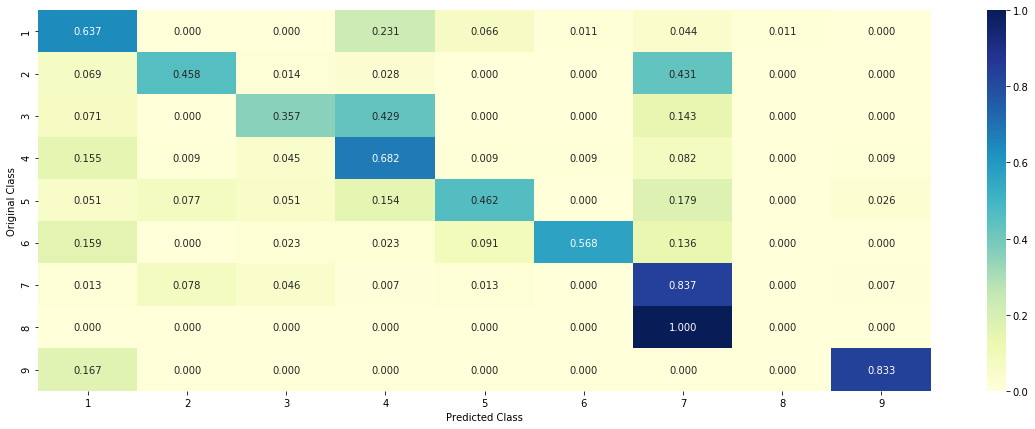

In [119]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [120]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 2
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1262 0.0926 0.0239 0.4485 0.1094 0.0405 0.1388 0.0124 0.0077]]
Actual Class : 6
--------------------------------------------------
159 Text feature [nonsense] present in test data point [True]
Out of the top  500  features  1 are present in query point


# Random Forest Classifier

## Model with One hot encoder

In [121]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for n_estimators = 100 and max depth =  5
Log Loss : 1.2395540192158805
for n_estimators = 100 and max depth =  10
Log Loss : 1.1815490769372705
for n_estimators = 200 and max depth =  5
Log Loss : 1.2220664883763848
for n_estimators = 200 and max depth =  10
Log Loss : 1.1756324701342746
for n_estimators = 500 and max depth =  5
Log Loss : 1.2249853881713215
for n_estimators = 500 and max depth =  10
Log Loss : 1.1715623570722065
for n_estimators = 1000 and max depth =  5
Log Loss : 1.222690484898759
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1697893224420308
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2227117820746582
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1685861870186114


In [122]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  2000 The train log loss is: 0.6721994848303379
For values of best estimator =  2000 The cross validation log loss is: 1.1685861870186114
For values of best estimator =  2000 The test log loss is: 1.1799264460514487


test it on testing data using best hyper param

Log loss : 1.1685861870186112
Number of mis-classified points : 0.40977443609022557
-------------------- Confusion matrix --------------------


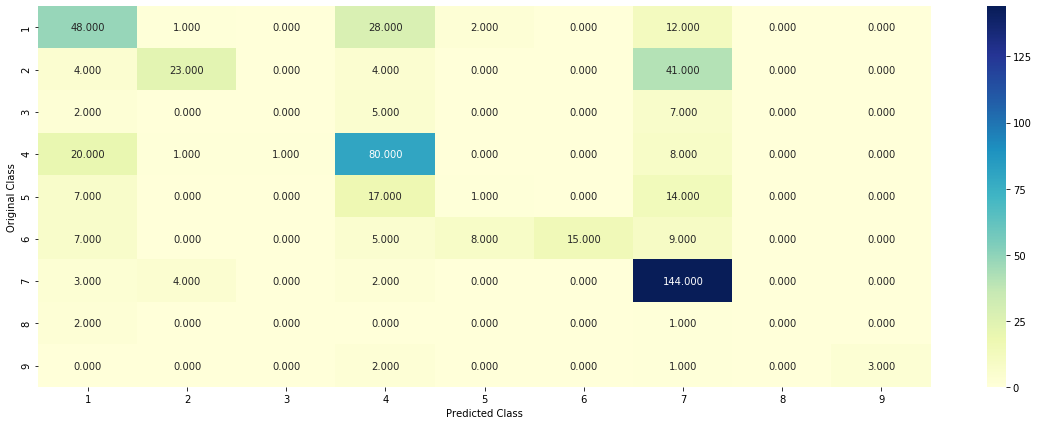

-------------------- Precision matrix (Columm Sum=1) --------------------


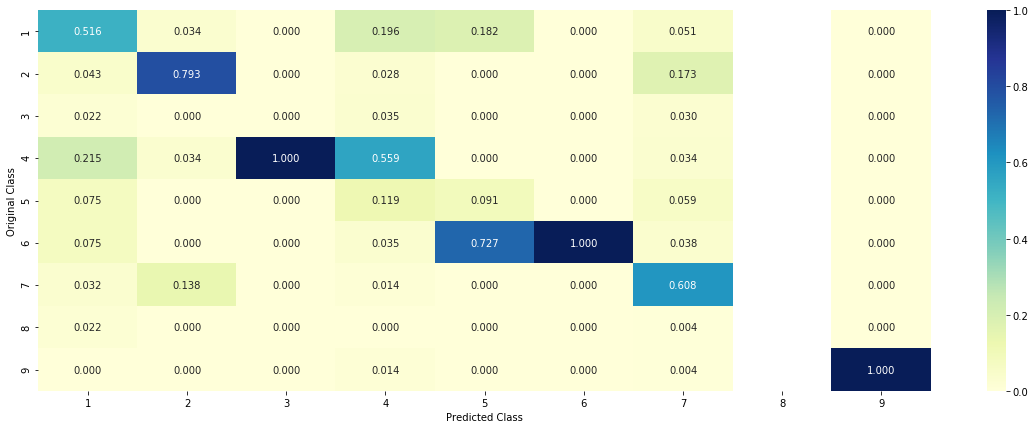

-------------------- Recall matrix (Row sum=1) --------------------


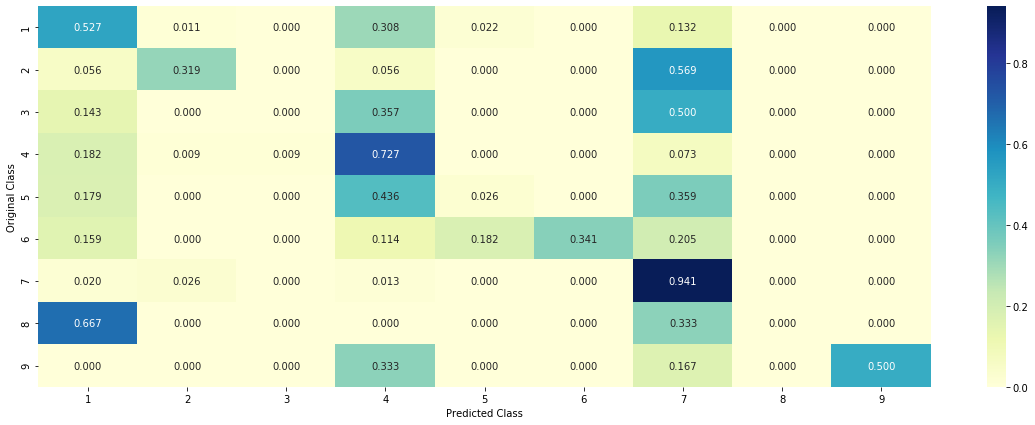

In [123]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [124]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0508 0.1442 0.0203 0.0482 0.0457 0.0372 0.6417 0.0062 0.0056]]
Actual Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [tyrosine] present in test data point [True]
3 Text feature [inhibitors] present in test data point [True]
4 Text feature [activation] present in test data point [True]
5 Text feature [inhibitor] present in test data point [True]
7 Text feature [activated] present in test data point [True]
8 Text feature [function] present in test data point [True]
9 Text feature [phosphorylation] present in test data point [True]
12 Text feature [erk] present in test data point [True]
13 Text feature [signaling] present in test data point [True]
14 Text feature [missense] present in test data point [True]
15 Text feature [oncogenic] present in test data point [True]
16 Text feature [akt

## RF with Response Coding

In [125]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.0443806331275916
for n_estimators = 10 and max depth =  3
Log Loss : 1.5821437717829205
for n_estimators = 10 and max depth =  5
Log Loss : 1.359688752747328
for n_estimators = 10 and max depth =  10
Log Loss : 1.8070688343949788
for n_estimators = 50 and max depth =  2
Log Loss : 1.604043050241583
for n_estimators = 50 and max depth =  3
Log Loss : 1.3939655141604028
for n_estimators = 50 and max depth =  5
Log Loss : 1.3120723737794004
for n_estimators = 50 and max depth =  10
Log Loss : 1.664798731762163
for n_estimators = 100 and max depth =  2
Log Loss : 1.4800195398037441
for n_estimators = 100 and max depth =  3
Log Loss : 1.3851778599538882
for n_estimators = 100 and max depth =  5
Log Loss : 1.2709562541646344
for n_estimators = 100 and max depth =  10
Log Loss : 1.6815015576516816
for n_estimators = 200 and max depth =  2
Log Loss : 1.4781725348129962
for n_estimators = 200 and max depth =  3
Log Loss : 1.3790894838610532


Testing model with best hyper param

Log loss : 1.270956254164634
Number of mis-classified points : 0.42293233082706766
-------------------- Confusion matrix --------------------


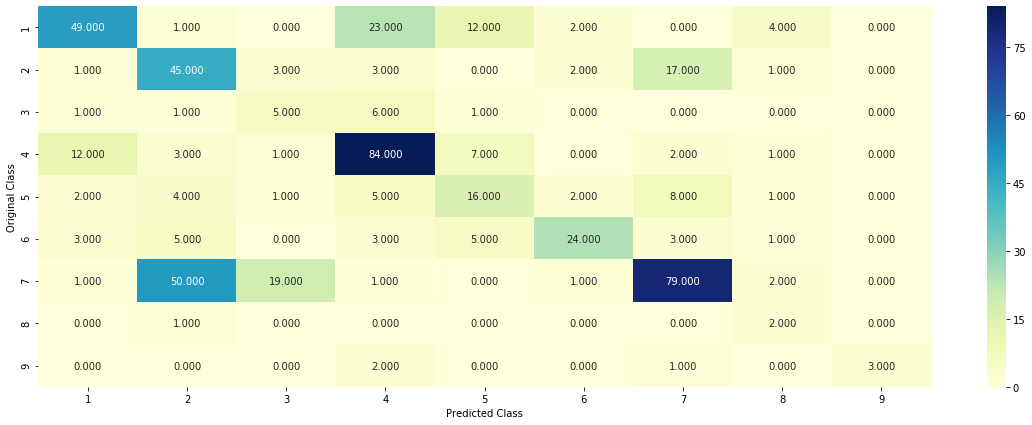

-------------------- Precision matrix (Columm Sum=1) --------------------


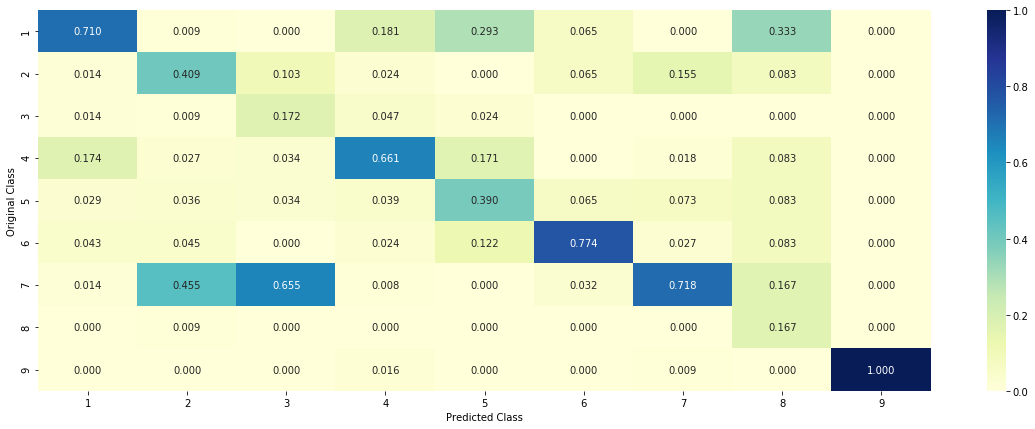

-------------------- Recall matrix (Row sum=1) --------------------


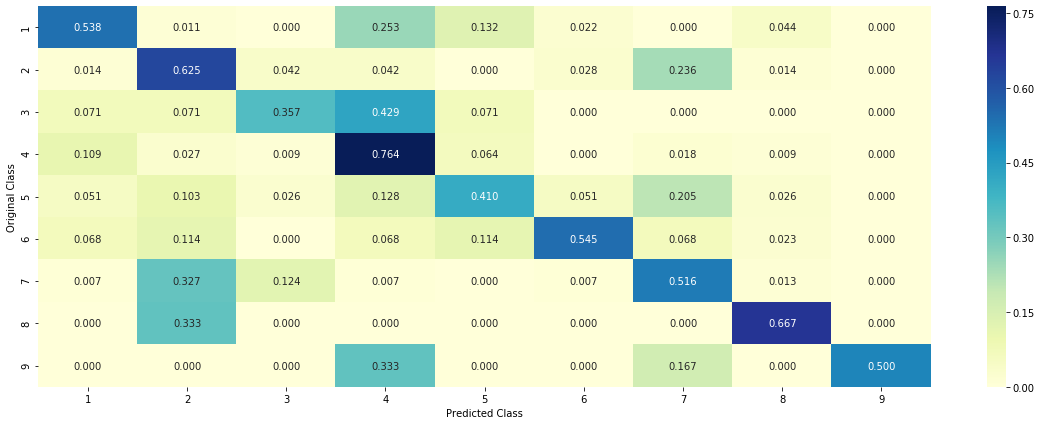

In [126]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

Query the classified point

In [127]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0202 0.3983 0.1105 0.0226 0.0307 0.0388 0.3312 0.0342 0.0136]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature


# Stacking model

In [128]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.18
Support vector machines : Log Loss: 1.72
Naive Bayes : Log Loss: 1.30
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.818
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.722
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.339
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.231
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.540
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.850


Testing with best hyper param

Log loss (train) on the stacking classifier : 0.4848980832812761
Log loss (CV) on the stacking classifier : 1.2312314387074468
Log loss (test) on the stacking classifier : 1.199508485156177
Number of missclassified point : 0.3669172932330827
-------------------- Confusion matrix --------------------


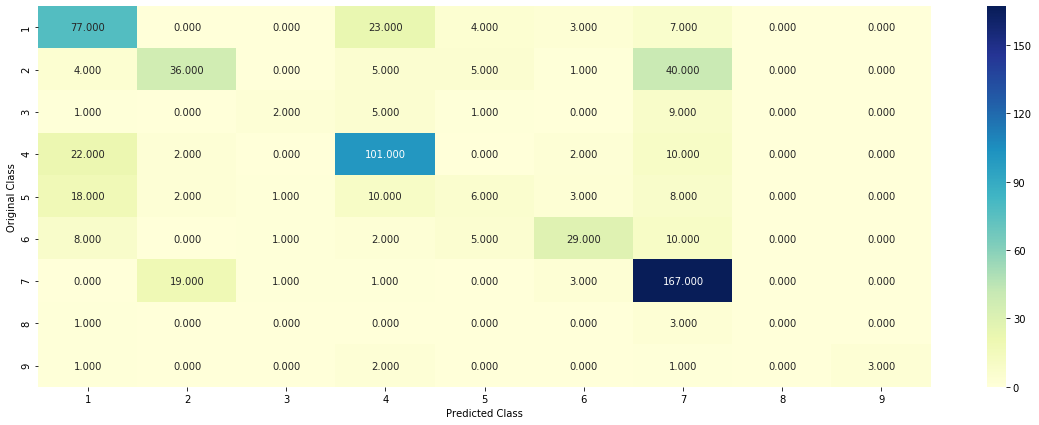

-------------------- Precision matrix (Columm Sum=1) --------------------


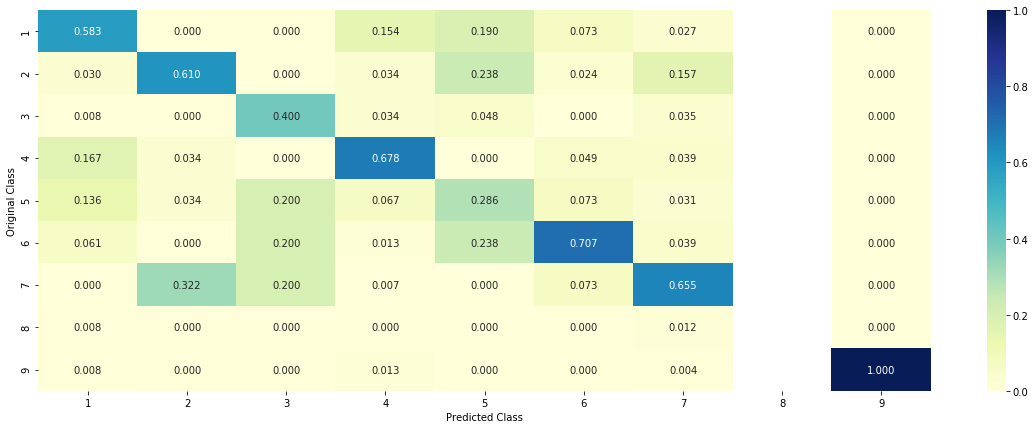

-------------------- Recall matrix (Row sum=1) --------------------


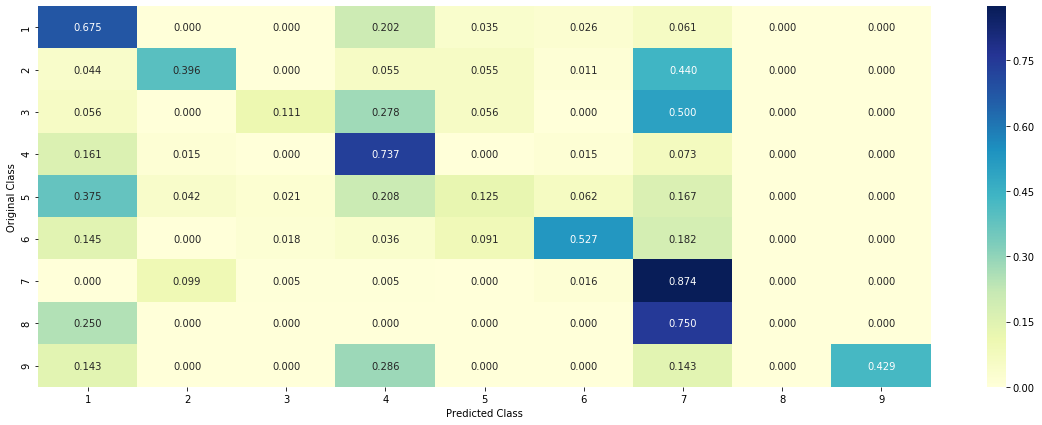

In [129]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

# Maximum voting Classifier

Log loss (train) on the VotingClassifier : 0.8544687457926832
Log loss (CV) on the VotingClassifier : 1.216160505833642
Log loss (test) on the VotingClassifier : 1.212912875891244
Number of missclassified point : 0.362406015037594
-------------------- Confusion matrix --------------------


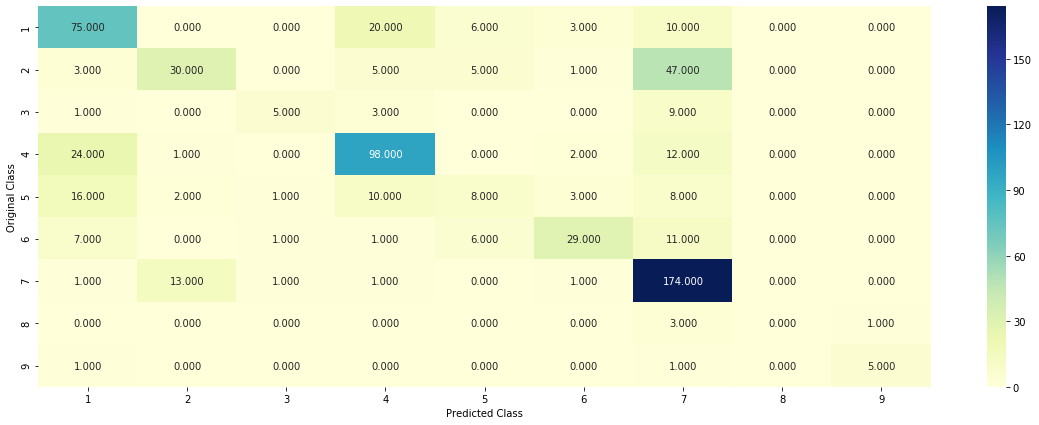

-------------------- Precision matrix (Columm Sum=1) --------------------


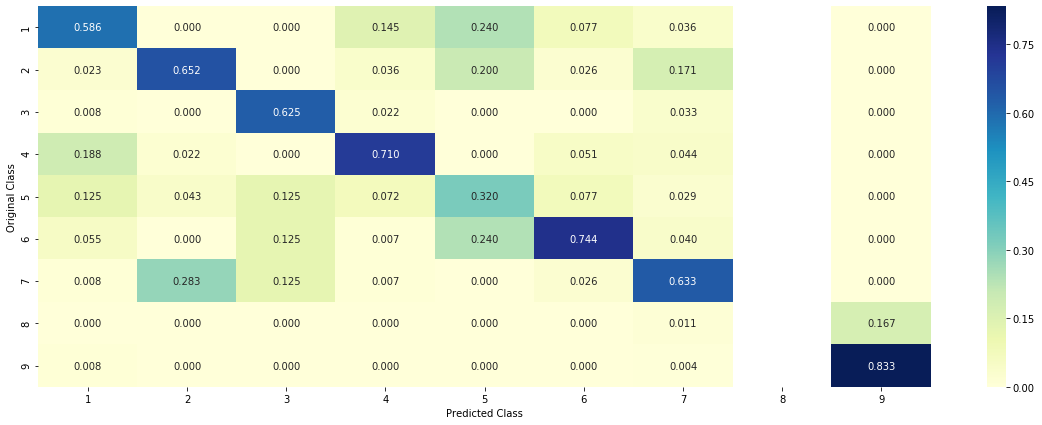

-------------------- Recall matrix (Row sum=1) --------------------


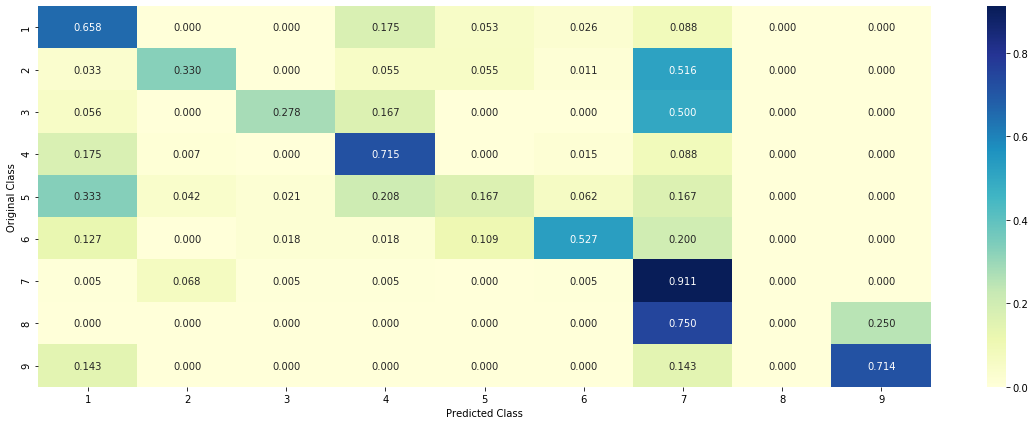

In [130]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))